In [1]:
import pandas as pd
from time import time
import numpy as np
from tqdm import tqdm
import os
import netCDF4 as nc
from progressbar import progressbar
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import datetime
from matplotlib import pyplot as plt, rcParams
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from scipy.ndimage import gaussian_filter
import xarray as xr
import random
from scipy.interpolate import LinearNDInterpolator
from itertools import product
from scipy.signal import savgol_filter
tqdm.pandas()

from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import numpy as np
from matplotlib.patches import Rectangle
from random import random
from scipy.signal import lombscargle

import matplotlib.ticker as mticker

%matplotlib inline

In [46]:
def filter_cygnss_df(df: pd.DataFrame, area: dict) -> pd.DataFrame:
    if 'sp_lat' in df.columns:
        new_df = df[df['sp_lat'] <= area['north']]
        new_df = new_df[new_df['sp_lat'] >= area['south']]
        new_df = new_df[new_df['sp_lon'] >= area['west']]
        new_df = new_df[new_df['sp_lon'] <= area['east']]
    else:
        new_df = df[df['lat'] <= area['north']]
        new_df = new_df[new_df['lat'] >= area['south']]
        new_df = new_df[new_df['long'] >= area['west']]
        new_df = new_df[new_df['long'] <= area['east']]

    return new_df


def filter_cygnss_day(df, start_day, end_day):
    filtered_df = df[df['day_of_year'] >= start_day]
    filtered_df = filtered_df[filtered_df['day_of_year'] < end_day]
    
    return filtered_df


def filter_smap_day(df, start_hour, end_hour):
    filtered_df = df[df['time'] >= start_hour]
    filtered_df = filtered_df[filtered_df['time'] < end_hour]
    return filtered_df


# Main time series for loop
def time_series_analysis(cygnss_df, smap_df, area, moving_window=2, interval=10, use_median=True, 
                         plot=True, area_name=None, save=None, use_smoothening=False, sigma=None,
                         error_bar_scale=10, flood_dates=None, part_series=False):
    
    cygnss_df = filter_cygnss_df(cygnss_df, area)
    smap_df = filter_cygnss_df(smap_df, area)
    
    first_day = cygnss_df['day_of_year'].min()
    last_day = cygnss_df['day_of_year'].max()
    
    if part_series:
        cygnss_df['day_of_year'] = cygnss_df['day_of_year'] - first_day
        smap_df['time'] = smap_df['time'] - first_day*24
        
    first_day = first_day - first_day
    last_day = last_day - first_day
    
    surface_ref = {}
    surface_ref_std = {}
    soil_moisture = {}
    soil_moisture_std = {}
    missing_smap_days = []
    
    for day in np.arange(first_day, last_day - moving_window, moving_window):
        # Filter CYGNSS
        current_cygnss = filter_cygnss_day(cygnss_df, day, day + interval)
        if use_smoothening:
            current_cygnss = grid_box(current_cygnss, 'sr', True)
            current_cygnss = smoothening(current_cygnss, area, sigma, 'sr')
        
        # Filter SMAP
        current_smap = filter_smap_day(smap_df, day*24, (day + interval)*24)
        
        if use_median:
            current_sr = current_cygnss['sr'].median()
            current_sr_std = current_cygnss['sr'].mad()
        else:
            current_sr = current_cygnss['sr'].mean()
            current_sr_std = current_cygnss['sr'].std()
        
        if len(current_smap) > 0:
            current_sm = current_smap['smap_sm'].mean()
            current_sm_std = current_smap['smap_sm'].std()
            soil_moisture[day] = current_sm
            soil_moisture_std[day] = current_sm_std
        else:
            missing_smap_days.append(day)
        
        surface_ref[day] = current_sr
        surface_ref_std[day] = current_sr_std
    
    if plot:

        fig = plt.figure(figsize=(22, 5))
        ax = plt.axes()
        ax.grid()
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        
        ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o")
        
        if flood_dates is not None:
            for flood in flood_dates:
                ax.axvspan(flood[0], flood[1], facecolor='grey', alpha=0.6)
        
        ax.set_ylabel("SR [dB]", color="red", fontsize=20)
        if part_series:
            ax.set_xlabel('Dager', fontsize=20)
        
        ax2 = ax.twinx()
        ax2.grid(False)
        ax2.plot(soil_moisture.keys(), soil_moisture.values(), color="blue", marker="o")
        ax2.set_ylabel("SM [cm^3/cm^3]", color="blue", fontsize=20)
        ax.legend(['Surface Reflectivity'], loc=2, fontsize=15)
        ax2.legend(['Soil Moisture'], loc=3, fontsize=15)
        
        ts_corr = calculate_correlation(surface_ref, soil_moisture)
        if area_name is not None:
            plt.title(area_name + " Correlation: " + str(round(ts_corr, 3)), fontsize=22)
            if save is not None:
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/' + str(area_name) + '.png', format='png')
        else:
            plt.title("Correlation: " + str(round(ts_corr, 3)), fontsize=18)
            if save is not None:
                random_num = lambda: random.randint(0, 255)
                random_name = '%02X%02X%02X' % (random_num(), random_num(), random_num())
                plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/Without Name' + random_name + '.png', format='png')
        
        plt.yticks(fontsize=20)
        plt.xticks(fontsize=20)
        if part_series:
            plt.xticks(fontsize=20)
        
        if not part_series:
            ax.xaxis.set_ticks([0, 121, 243, 365, 488, 609, 731, 852, 974, 1094])
            ax.set_xticklabels(['Jan 2019', 'May 2019', 'Sep 2019', 
                                'Jan 2020', 'May 2020', 'Sep 2020', 
                                'Jan 2021', 'May 2021', 'Sep 2021',
                                'Jan 2022'],
                                fontsize=20,
                                rotation=30)
            
        plt.xticks(fontsize=20)
        
        plt.show()
        
    return surface_ref, surface_ref_std, soil_moisture, soil_moisture_std


def calculate_correlation(sr_dict, sm_dict):
    
    sr_list = []
    sm_list = []
    
    for key in sm_dict.keys():
        sr_list.append(sr_dict[key])
        sm_list.append(sm_dict[key])
        
    return pd.Series(sr_list).corr(pd.Series(sm_list))
    

def overall_time_series_plot(correlations):
    special_regions = [max(correlations, key=correlations.get)]

    fig, ax = plt.subplots(figsize=(9, 9))

    plt.xlim([selected_area['west'], selected_area['east']])
    plt.ylim([selected_area['south'], selected_area['north']])
    
    x_places = list(range(selected_area['west'], selected_area['east'] + 1))
    y_places = list(range(selected_area['south'], selected_area['north'] + 1))
    x_labels = [str(i) for i in x_places]
    y_labels = [str(i) for i in y_places]
    
    ax.xaxis.set_ticks(x_places)
    ax.set_xticklabels(x_labels, fontsize=17)
    ax.yaxis.set_ticks(y_places)
    ax.set_yticklabels(y_labels, fontsize=17)


    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    # Scaling opacity values
    max_corr = max(list(correlations.values()))
    min_corr = min(list(correlations.values()))
    diff_corr = max_corr - min_corr

    correlations_scaled = {}

    for key in correlations:
        correlations_scaled[key] = (correlations[key] - min_corr)/diff_corr


    index = 0
    for x in np.arange(selected_area['west'], selected_area['east'] - 0.05, 0.5):
        for y in np.arange(selected_area['south'], selected_area['north'] - 0.05, 0.5):
            if (x, y) not in special_regions:
                current_corr = round(correlations[(x, y)], 3)
                ax.text(x + 0.25, y + 0.25, current_corr, fontsize=14, verticalalignment='center', horizontalalignment='center')
                ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='green', alpha=correlations_scaled[(x, y)]))
            else:
                # ax.text(x + 0.25, y + 0.25, alphabet[index], fontsize=14, verticalalignment='center', horizontalalignment='center', weight='bold')
                if correlations[(x, y)] == max_corr:
                    ax.text(x + 0.25, y + 0.25, round(correlations[(x, y)], 3), fontsize=14, verticalalignment='center', horizontalalignment='center')
                    ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='blue', alpha=0.8))
                else:
                    ax.text(x + 0.25, y + 0.25, round(correlations[(x, y)], 3), fontsize=14, verticalalignment='center', horizontalalignment='center')
                    ax.add_patch(Rectangle((x, y), 0.5, 0.5, color='red'))
                index = index + 1


    plt.title(selected_area_string + ' Overview Correlation Between \nCYGNSS and SMAP for 2019 - 2021', fontsize=30)
    
    ax.set_xlabel('Longitude [degree]', fontsize=20)
    ax.set_ylabel('Latitude [degree]', fontsize=20)

    plt.tight_layout()

    plt.grid(color='black', linewidth=1)
    plt.show()

        


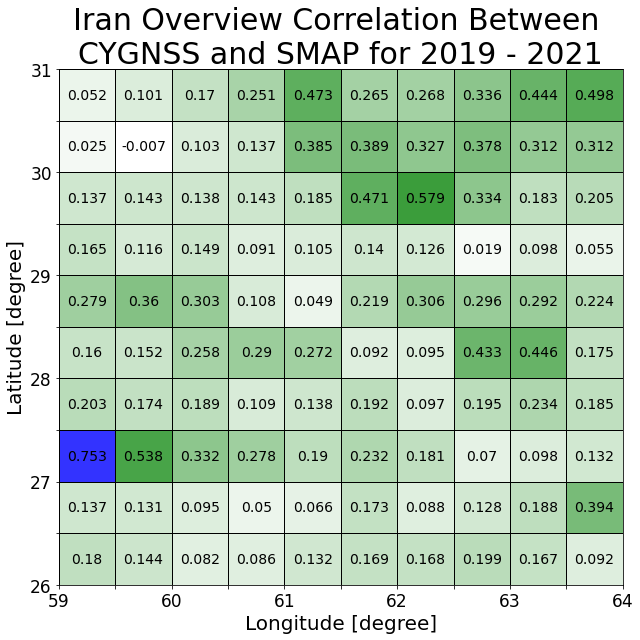

Best region bottom left corner: (59.0, 27.0)


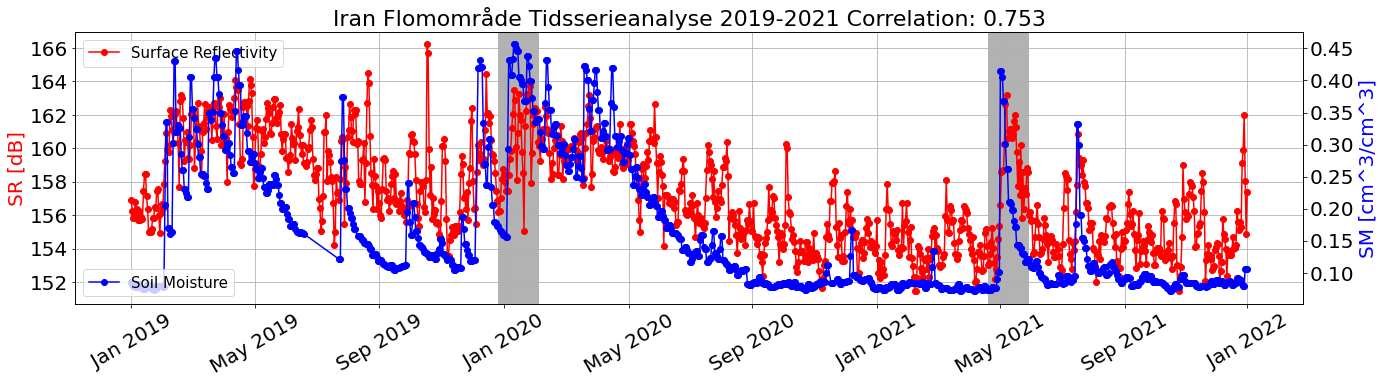

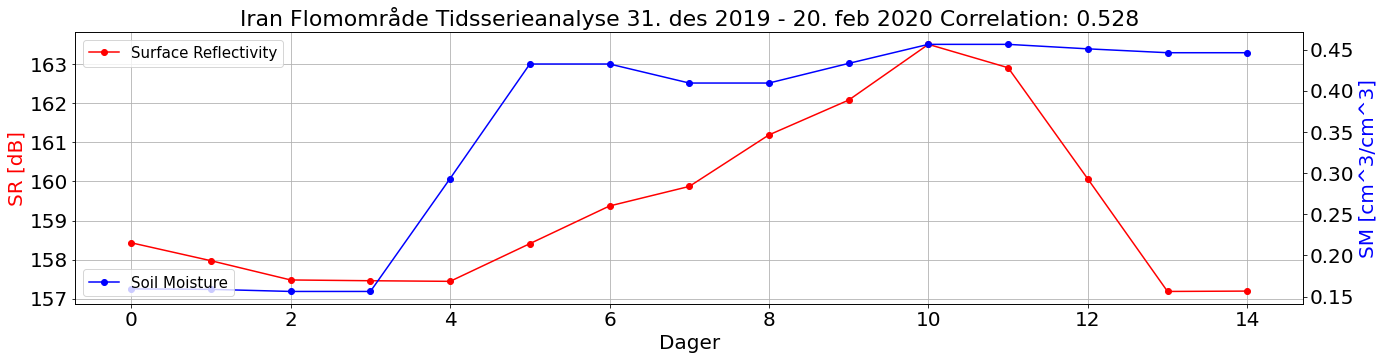

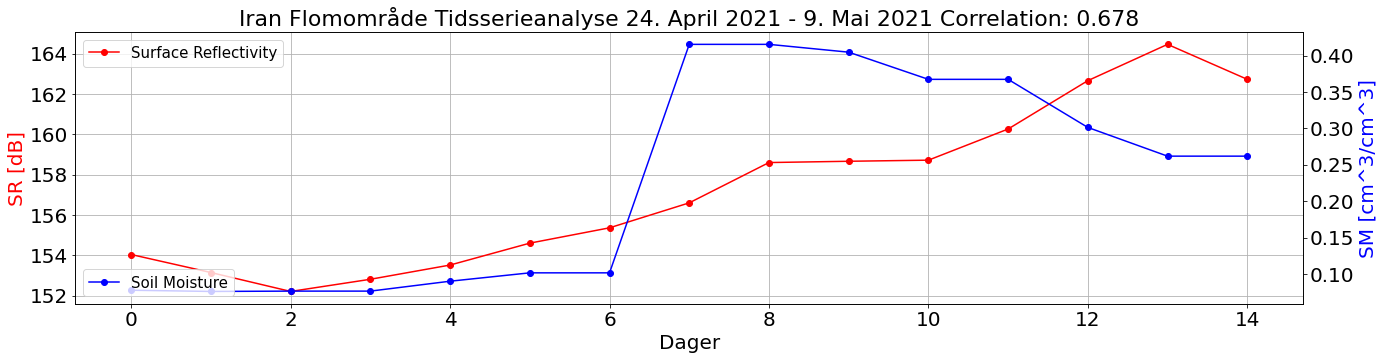

In [47]:
# Main Iran Analysis
selected_area_string = 'Iran'
selected_area = {'north': 31, 'south': 26, 'west': 59, 'east': 64}
selected_cygnss_path = '/Volumes/Seagate Ekstern Hardisk/Processed Files/31-59-26-64/CYGNSS 2019 to 2021'
selected_smap_path = '/Users/vegardhaneberg/Desktop/Prosessed SMAP 3 years/Iran 2019-2021.csv'

raw_cygnss_df = pd.read_csv(selected_cygnss_path)[['sp_lat', 'sp_lon', 'day_of_year', 'sp_inc_angle', 'sr']].rename(columns={'sp_lat': 'lat', 'sp_lon': 'long'})
raw_smap_df = pd.read_csv(selected_smap_path)[['lat', 'long', 'time', 'smap_sm']]

moving_window = 1  # Number of days to be skipped between each data point in the time series
interval = 3 # The number of days to be averaged in each data point in the time series

correlations = {}
# Time series for each 0.5 x 0.5 degrees area
for lat in np.arange(selected_area['south'], selected_area['north'] - 0.5 + 0.05, 0.5):
    for long in np.arange(selected_area['west'], selected_area['east'] - 0.5 + 0.05, 0.5):
        current_area = {'north': round(lat, 1) + 0.5, 
                        'south': round(lat, 1), 
                        'west': round(long, 1), 
                        'east': round(long, 1) + 0.5}
        current_area_string = 'Bottom left corner: (' + str(round(lat, 1)) + ', ' + str(round(long, 1)) + ')'
        
        current_cygnss = filter_cygnss_df(raw_cygnss_df, current_area)
        current_smap = filter_cygnss_df(raw_smap_df, current_area)
        
        sr, sr_std, sm, sm_std, = time_series_analysis(current_cygnss,
                                                       current_smap,
                                                       current_area,
                                                       moving_window,
                                                       interval,
                                                       True,
                                                       False,
                                                       current_area_string)
        correlations[(long, lat)] = calculate_correlation(sr, sm)

overall_time_series_plot(correlations)

flood_dates = [(360, 400), (840, 880)]

# Time series best region
best_region_corner = max(correlations, key=correlations.get)
print('Best region bottom left corner:', best_region_corner)
best_region = {'north': best_region_corner[1] + 0.5, 
               'south': best_region_corner[1], 
               'west': best_region_corner[0], 
               'east': best_region_corner[0] + 0.5}
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_df(raw_cygnss_df, best_region), 
                                               filter_cygnss_df(raw_smap_df, best_region), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               'Iran Flomområde Tidsserieanalyse 2019-2021',
                                               save=None,
                                               flood_dates=flood_dates)


# Time series first flood
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_day(filter_cygnss_df(raw_cygnss_df, best_region), flood_dates[0][0] + 5, flood_dates[0][1] - 20), 
                                               filter_smap_day(filter_cygnss_df(raw_smap_df, best_region), (flood_dates[0][0] + 5)*24, (flood_dates[0][1] - 20)*24), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               'Iran Flomområde Tidsserieanalyse 31. des 2019 - 20. feb 2020',
                                               save=None,
                                               part_series=True)

# Time series second flood
sr, sr_std, sm, sm_std, = time_series_analysis(filter_cygnss_day(filter_cygnss_df(raw_cygnss_df, best_region), flood_dates[1][0] + 5, flood_dates[1][1] - 20), 
                                               filter_smap_day(filter_cygnss_df(raw_smap_df, best_region), (flood_dates[1][0] + 5)*24, (flood_dates[1][1] - 20)*24), 
                                               best_region,
                                               moving_window, 
                                               interval, 
                                               True, 
                                               True,
                                               'Iran Flomområde Tidsserieanalyse 24. April 2021 - 9. Mai 2021',
                                               save=None,
                                               part_series=True)




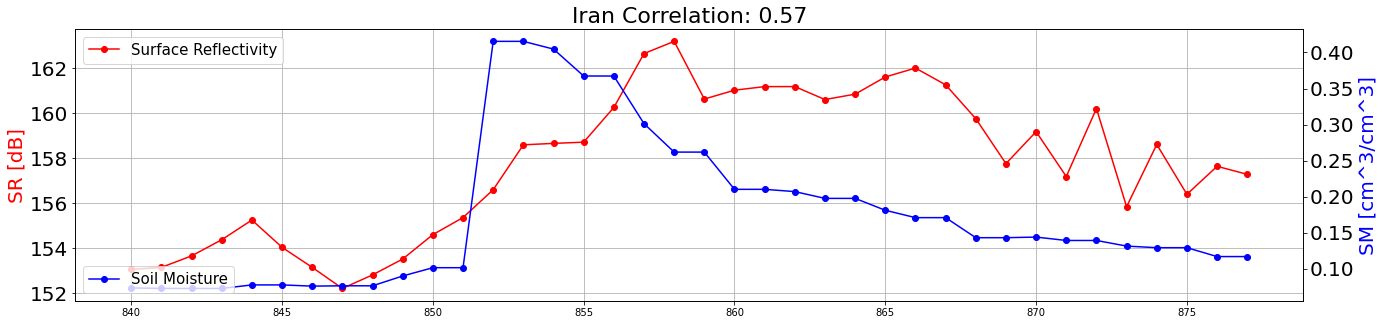

In [32]:
area_name = 'Iran'
save = None


surface_ref = sr
surface_ref_std = sr_std
soil_moisture = sm
soil_moisture_std = sm_std

fig = plt.figure(figsize=(22, 5))
ax = plt.axes()
ax.grid()
plt.yticks(fontsize=20)


ax.plot(surface_ref.keys(), surface_ref.values(), color="red", marker="o")

ax.set_ylabel("SR [dB]", color="red", fontsize=20)

ax2 = ax.twinx()
ax2.grid(False)
ax2.plot(soil_moisture.keys(), soil_moisture.values(), color="blue", marker="o")
ax2.set_ylabel("SM [cm^3/cm^3]", color="blue", fontsize=20)
ax.legend(['Surface Reflectivity'], loc=2, fontsize=15)
ax2.legend(['Soil Moisture'], loc=3, fontsize=15)

ts_corr = calculate_correlation(surface_ref, soil_moisture)
if area_name is not None:
    plt.title(area_name + " Correlation: " + str(round(ts_corr, 3)), fontsize=22)
    if save is not None:
        plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/' + str(area_name) + '.png', format='png')
else:
    plt.title("Correlation: " + str(round(ts_corr, 3)), fontsize=18)
    if save is not None:
        random_num = lambda: random.randint(0, 255)
        random_name = '%02X%02X%02X' % (random_num(), random_num(), random_num())
        plt.savefig('/Users/vegardhaneberg/Desktop/Plots Master/Time Series/Without Name' + random_name + '.png', format='png')

plt.yticks(fontsize=20)

"""
ax.xaxis.set_ticks([0, 121, 243, 365, 488, 609, 731, 852, 974, 1094])

ax.set_xticklabels(['Jan 2019', 'May 2019', 'Sep 2019', 
                    'Jan 2020', 'May 2020', 'Sep 2020', 
                    'Jan 2021', 'May 2021', 'Sep 2021',
                    'Jan 2022'],
                    fontsize=20,
                    rotation=30)
"""

plt.show()